#upload kaggle json file

In [ ]:
!pip install kaggle
from google.colab import files 
files.upload() # upload json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d gakowsher/banglamct7-bangla-multiclass-text-dataset-7-tags

 96% 322M/335M [00:02<00:00, 127MB/s]
100% 335M/335M [00:02<00:00, 141MB/s]


In [ ]:
from zipfile import ZipFile
file_name= "banglamct7-bangla-multiclass-text-dataset-7-tags.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import output


In [ ]:
import re
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
!pip install bangla-stemmer
!pip install py-bangla-stemmer #2

import seaborn as sns
import matplotlib.pyplot as plt

  Created wheel for py-bangla-stemmer: filename=py_bangla_stemmer-0.5.1-py3-none-any.whl size=17351 sha256=ffaa75bb8716a963301d515cc2b55605742d0bb1cffd9263332f16724d4e179b
  Stored in directory: /root/.cache/pip/wheels/30/bc/a9/37aed1bed9523e97e10d89ff21a92d82026b88974be8931336
Successfully built py-bangla-stemmer


#Read dataset

In [ ]:
train_data=pd.read_csv('/content/BanglaMCT7/train.csv')
test_data = pd.read_csv('/content/BanglaMCT7/test.csv')

In [ ]:
train_data.head()

,category,text,cleanText
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...


In [ ]:
train_data.text.iloc[5]

'খুদে ব্লগ লেখার জনপ্রিয় সাইট টুইটার এখন বাংলা ভাষায় দেখা যাবে। টুইটারের মূল ওয়েবসাইটের পাশাপাশি মোবাইল ওয়েবসাইট(mobile.twitter.com), অ্যান্ড্রয়েড ও আইওএস অ্যাপ্লিকেশনে (অ্যাপ) বাংলা সমর্থনের সুবিধা চালু করেছে। এর ফলে সম্পূর্ণ বাংলায় বার্তা (টুইট) লেখা ও পড়া যাবে। বাংলা ছাড়াও সম্প্রতি ভিয়েতনামিস, চেক, রোমানিয়ান ও ইউক্রেনিয়ান ভাষা যুক্ত হয়েছে টুইটারে। বিভিন্ন ভাষাভাষীর স্বেচ্ছাসেবকদের অনুবাদ করা এসব ভাষা এর আগে শুধু অনুবাদকাজের সঙ্গে যুক্ত স্বেচ্ছাসেবকদের জন্য উন্মুক্ত ছিল।গতকাল মঙ্গলবার থেকে এসব ভাষার সুবিধা সাধারণ ব্যবহারকারীদের জন্য উন্মুক্ত করা হয়েছে। বাংলা কিংবা অন্যান্য ভাষা নির্বাচন করতে টুইটারের সেটিংস থেকে ভাষা অপশনে গিয়ে পছন্দের ভাষা বেছে নিতে হবে।চাইলে যে কেউ টুইটারের এ ভাষা অনুবাদেও যুক্ত হতে পারেন। এতে নির্দিষ্ট শব্দ কিংবা লাইনের সঠিক অর্থ লিখে জমা দেওয়া যাবে। সেখান থেকে নির্বাচিত এবং সঞ্চালক কর্তৃক পরীক্ষিত হওয়ার পর সেটি মূল টুইটারে বাংলা ভাষায় যুক্ত হবে। আগ্রহীরা (translate.twitter.com) ঠিকানায় গিয়ে বাংলা অনুবাদে যুক্ত হতে পারেন।উল্লেখ্য, ২০০৬ সালে মাত্র ১৪০ শব্দের মধ্

In [ ]:
train_data.cleanText.iloc[5]

'  খুদে    ব্লগ    লেখার    জনপ্রিয়    সাইট    টুইটার    বাংলা    ভাষায়    টুইটারের    মূল    ওয়েবসাইটের    পাশাপাশি    মোবাইল    ওয়েবসাইট    অ্যান্ড্রয়েড    আইওএস    অ্যাপ্লিকেশনে    অ্যাপ    বাংলা    সমর্থনের    সুবিধা    চালু    সম্পূর্ণ    বাংলায়    বার্তা    টুইট    লেখা    পড়া    বাংলা    ছাড়াও    ভিয়েতনামিস    চেক    রোমানিয়ান    ইউক্রেনিয়ান    ভাষা    যুক্ত    টুইটারে    বিভিন্ন    ভাষাভাষীর    স্বেচ্ছাসেবকদের    অনুবাদ    এসব    ভাষা    অনুবাদকাজের    যুক্ত    স্বেচ্ছাসেবকদের    উন্মুক্ত    গতকাল    মঙ্গলবার    এসব    ভাষার    সুবিধা    সাধারণ    ব্যবহারকারীদের    উন্মুক্ত    বাংলা    অন্যান্য    ভাষা    নির্বাচন    টুইটারের    সেটিংস    ভাষা    অপশনে    পছন্দের    ভাষা    বেছে    চাইলে    টুইটারের    ভাষা    অনুবাদেও    যুক্ত    নির্দিষ্ট    শব্দ    লাইনের    সঠিক    অর্থ    লিখে    জমা    নির্বাচিত    সঞ্চালক    কর্তৃক    পরীক্ষিত    মূল    টুইটারে    বাংলা    ভাষায়    যুক্ত    আগ্রহীরা    ঠিকানায়    বাংলা    অনুবাদে    যুক্ত    উল্লেখ্য    সালে    শব্দের    খুদে    ব্লগ 

In [ ]:
test_data.head()

,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...


In [ ]:
train_data

,category,text,cleanText
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...
...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...


In [ ]:
test_data

,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...
...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [ ]:
train_data.category.value_counts()

sports           15672
international    15540
state            15362
entertainment    15198
economy          14430
education        12674
technology       10007
Name: category, dtype: int64

In [ ]:
test_data.category.value_counts()

sports           15883
international    15314
entertainment    15261
state            15183
economy          14488
education        12818
technology        9937
Name: category, dtype: int64

In [ ]:
print(train_data.isna().sum())

category     0
text         0
cleanText    0
dtype: int64


In [ ]:
print(test_data.isna().sum())

category     0
text         0
cleanText    0
dtype: int64


#Data Processing:

In [ ]:
labels= train_data.category.unique()
label_dict={}

for index,possible_label in enumerate(labels):
  label_dict[possible_label]=index

train_data['label']=train_data.category.replace(label_dict)
test_data['label']=test_data.category.replace(label_dict)

train_data.head()

,category,text,cleanText,label
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,0
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,1
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,2
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,3
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,1


In [ ]:
label_dict

{'economy': 0,
 'education': 6,
 'entertainment': 5,
 'international': 2,
 'sports': 1,
 'state': 3,
 'technology': 4}

In [ ]:
def remove_space(x):
  x= re.sub('\s+',' ',x)
  return x

train_data['cleanText']= train_data['cleanText'].apply(remove_space)
test_data['cleanText']=test_data['cleanText'].apply(remove_space)

In [ ]:
from collections import Counter
result = len(set(Counter(" ".join(train_data['cleanText'].values.tolist()).split(" ")).items()))
result

464249

In [ ]:
# from bangla_stemmer.stemmer import stemmer
# def stem_text (x):
#   stmr = stemmer.BanglaStemmer()
#   words=x.split(' ')
#   stm = stmr.stem(words)
#   words=(' ').join(stm)
#   output.clear()
#   return words

# train_data['cleanText']=train_data['cleanText'].apply(stem_text)




In [ ]:
# train_data.to_csv('train_data_stemmer.csv')

In [ ]:
# test_data['cleanText']=train_data['cleanText'].apply(stem_text)

In [ ]:
# test_data.to_csv('test_data_stemmer.csv')

In [ ]:

result = len(set(Counter(" ".join(train_data['cleanText'].values.tolist()).split(" ")).items()))
result

#before stemming the sentence: 464249
#after stemming the sentence: 356168

464249

In [ ]:
test1, val1 =train_test_split(test_data, random_state=22, test_size=0.2 , stratify=test_data['label'])

train_sentence = train_data['cleanText'].values
test_sentence = test1['cleanText'].values
val_sentence = val1['cleanText'].values

train_label = train_data['label'].values
test_label = test1['label'].values
val_label = val1['label'].values

train_labels= pd.get_dummies(train_label).values
test_labels = pd.get_dummies(test_label).values
val_labels= pd.get_dummies(val_label).values


In [ ]:
test1.category.value_counts()

sports           12706
international    12251
entertainment    12209
state            12146
economy          11590
education        10255
technology        7950
Name: category, dtype: int64

In [ ]:
val1.category.value_counts()

sports           3177
international    3063
entertainment    3052
state            3037
economy          2898
education        2563
technology       1987
Name: category, dtype: int64

In [ ]:
print(train_sentence[10])
print(train_labels[10])

 শফিক তুহিনের সুর সংগীত পরিচালনায় চলচ্চিত্রের গানে কণ্ঠ তাঁরই ভাই জাহাঙ্গীর গতকাল শুক্রবার রাজধানীর মোহাম্মদপুরের স্টুডিওতে গানটির রেকর্ডিং জাকির হোসেন রাজু পরিচালিত ছবিটির নাম মনের পাইলাম শফিক তুহিন গানের ভাইয়া ঢাকায় আসেন ভাইয়ার কারণে আমিও একটা সময় নিজেকে গানের যুক্ত ক্যারিয়ার গড়তে হতো গানে আজকে সবকিছুই ভাইয়ার কারণেই শফিক তুহিন ভাইয়া সুর সংগীত পরিচালনায় কাজ একটা এদিকে শফিক তুহিনের ভাই জাহাঙ্গীর প্রথম আলো ডটকমকে আসলে গানের জন্যই ঢাকায় আসা আটটি একক গানের অ্যালবাম প্রকাশিত গেয়েছি মিশ্র অ্যালবামে ছোট ভাইয়ের সুর সংগীত পরিচালনায় চলচ্চিত্রের গানে কণ্ঠ দিলাম টাইটেল সংগীত পুরো বিষয়টি বেশি আনন্দের পাশাপাশি বেশি আবেগও কাজ গানটিতে কণ্ঠ গাড়িতে উঠেই প্রথম মাকে ফোন জানালাম মিলিয়ে আসলেই অন্যরকম অনুভূতি এবারের সিটিসেল চ্যানেল সংগীত পুরস্কারে শফিক তুহিন সেরা গীতিকারের পুরস্কার অর্জন একক গানের অ্যালবাম পাগলামি তুহিন পুরস্কার পান 
[0 0 0 0 0 1 0]


In [ ]:
print(test_sentence[10])
print(test_labels[10])

 খ্রিস্টান সম্প্রদায়ের ধর্মীয় উত্সব বড়দিন উপলক্ষে রবিবার দিনাজপুরের হিলি স্থলবন্দর পণ্য আমদানি রফতানি কার্যক্রম বন্ধ স্থলবন্দর বাংলাদেশ ভারতের প্রকার পণ্য আমদানি রফতানি ইমিগ্রেশন চেকপোস্টের পাসপোর্টে যাত্রী পারাপার চালু এছাড়াও বন্দরের বেসরকারি ওয়্যার হাউজ পানামা পোর্টের অভ্যন্তরে পণ্য উঠা নামার কাজও বন্ধ সোমবার যথারীতি বন্দরের পণ্য আমদানি রফতানিসহ সার্বিক কার্যক্রম স্বাভাবিক নিয়মে চলবে বাংলাহিলি কাস্টমস সিএন্ডএফ এজেন্টস এসোসিয়েশনের সভাপতি কামাল হোসেন রাজ বড়দিন উপলক্ষে বন্দরের দুই অংশের ব্যবসায়ীরা বন্দরের সকল কার্যক্রম বন্ধ রাখার সিদ্ধান্ত নেন কারণে সকাল বন্দর আমদানি রফতানি কার্যক্রমসহ পণ্য লোড আনলোড বন্ধ ইত্তেফাক এএসএস 
[1 0 0 0 0 0 0]


In [ ]:
 test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
 3   label      98884 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [ ]:
# test_data.dropna(subset=['cleanText'], inplace=True)

#Tokenization and padding

In [ ]:
vocab_size = 200000
embedding_dim = 300
max_length = 4000
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentence)
word_index = tokenizer.word_index



print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentence)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)



464246
Word index length:464246


In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentence)
test_padded = pad_sequences(test_sequences,maxlen=max_length)

In [ ]:

val_sequences = tokenizer.texts_to_sequences(val_sentence)
val_padded = pad_sequences(val_sequences,maxlen=max_length)

#CNN Model

In [ ]:
from keras.layers import MaxPool1D
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
#l2 regularizer
model.add(Dense(20,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Dense(7, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4000, 300)         60000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3998, 200)         180200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1999, 200)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1999, 200)         0         
_________________________________________________________________
flatten (Flatten)            (None, 399800)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               39980100  
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5

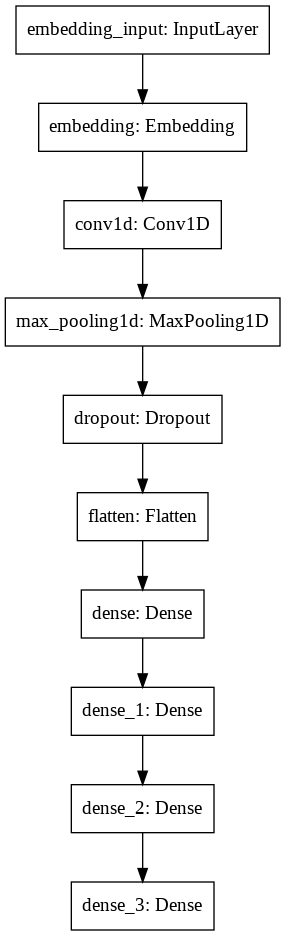

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model)

In [ ]:
history=model.fit(padded,train_labels,epochs=5,batch_size=128,validation_data=(val_padded,val_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
773/773 [==============================] - 495s 600ms/step - loss: 0.5992 - accuracy: 0.8354 - val_loss: 0.2751 - val_accuracy: 0.9378
Epoch 2/5
773/773 [==============================] - 463s 599ms/step - loss: 0.1478 - accuracy: 0.9709 - val_loss: 0.2592 - val_accuracy: 0.9356
Epoch 3/5
773/773 [==============================] - 464s 600ms/step - loss: 0.0573 - accuracy: 0.9910 - val_loss: 0.3194 - val_accuracy: 0.9337
Epoch 4/5
773/773 [==============================] - 463s 599ms/step - loss: 0.0293 - accuracy: 0.9959 - val_loss: 0.3399 - val_accuracy: 0.9348
Epoch 5/5
773/773 [==============================] - 462s 597ms/step - loss: 0.0215 - accuracy: 0.9964 - val_loss: 0.4248 - val_accuracy: 0.9275


#Model Evaluation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


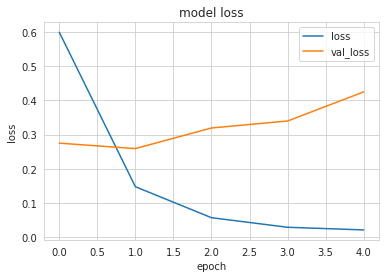

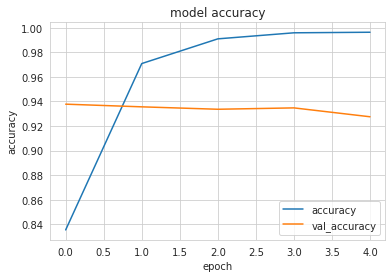

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=128)
print("The train accuracy is: "+str(loss_and_metrics[1]))


773/773 [==============================] - 124s 160ms/step - loss: 0.0184 - accuracy: 0.9972
The train accuracy is: 0.9971582293510437


In [ ]:
loss_and_metrics = model.evaluate(test_padded,test_labels,batch_size=128)
print("The test accuracy is: "+str(loss_and_metrics[1]))

619/619 [==============================] - 99s 160ms/step - loss: 0.4394 - accuracy: 0.9268


In [ ]:
predictions = model.predict(test_padded)
pred1 = np.argmax(predictions , axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
test_labels = np.argmax(test_labels,axis=1)

#Classification Scores

In [ ]:

print(classification_report(test_labels , pred1))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11590
           1       0.99      0.98      0.98     12706
           2       0.95      0.91      0.93     12251
           3       0.86      0.91      0.88     12146
           4       0.89      0.89      0.89      7950
           5       0.96      0.95      0.95     12209
           6       0.95      0.94      0.94     10255

    accuracy                           0.93     79107
   macro avg       0.93      0.92      0.92     79107
weighted avg       0.93      0.93      0.93     79107



In [ ]:
accuracy_score(test_labels , pred1)

0.926757429810257

#Confusion Matrix

In [ ]:
confusion_matrix(test_labels , pred1)

array([[10550,    22,    60,   599,   229,    31,    99],
       [   55, 12413,    79,    48,    37,    73,     1],
       [  115,    57, 11097,   436,   349,   169,    28],
       [  486,    16,   131, 11020,    52,   144,   297],
       [  524,    16,   143,    48,  7072,    44,   103],
       [   30,    34,   115,   383,    48, 11571,    28],
       [   98,     4,    27,   323,   152,    61,  9590]])